# Motivational quotes generation using character/BPE GRU
### Based on course ["Нейронные сети и обработка текста"](https://stepik.org/course/54098/)

If you are going to read this notebook, I recommend you to open it in [google colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true) and start reading from [the beginning of the analysis](#scrollTo=rPtOSQEdx3sH), using the attached hyperlinks on functions and classes if you need to.

### Some examples of character GRU model work:

 - "The condition of the buildings are real wrongs of the people."
 - "I am not a real impact on the table of God"
 - "I want to lose my life being weird. I'm not that bus up, emotion, and that's what I've been turned."
 - "The real liberation of it is the result of right."
 - "I think the best way to do is to love it all the time."
 - "I don't really care about the truth."
 - "I am not an award-centrance. I'm big and I'm very lucky."

with start phrase "Neural networks":
 - "Neural networks are decisivenial, no nature, and we need to struggle detective news we are passionate."
 - "Neural networks are only bread neuronds of their connection; they can only give a character than to go to their projects."
 - "Neural networks is a compliment to a new enemy."
 - "Neural networks have a very common struggle for me."
 - "Neural networks can be a gentleman in the universe."
 - "Neural networks from the present of the earth is the best construction of the pressure of being able to continue to destroy the results of the world."
 - "Neural networks and their opinion is the best thing I love."

## Required libraries, functions and classes:

In [1]:
!pip3 install livelossplot --quiet
!pip3 install youtokentome --quiet

     |████████████████████████████████| 1.7MB 17.4MB/s 


In [2]:
from google.colab import drive, files

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

import youtokentome as yttm

import random

from tqdm.notebook import tqdm

import datetime

from livelossplot import PlotLosses

from traceback import format_exc

from copy import deepcopy

In [3]:
def init_random_seed(value=0):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    torch.backends.cudnn.deterministic = True

init_random_seed()

In [4]:
def copy_data_to_device(data, device):
    if torch.is_tensor(data):
        return data.to(device)
    elif isinstance(data, (list, tuple)):
        return [copy_data_to_device(elem, device) for elem in data]
    raise ValueError('Invalid data type {}'.format(type(data)))

In [5]:
def divisors(n):
    """Find all divisors of a number"""
    i = 1
    divisors = []
    while i <= n**0.5:
        if (n % i == 0) : 
            if (n / i == i):
                divisors.append(i)
            else:
                divisors.extend([i, n // i])
        i = i + 1
    return sorted(divisors)

In [6]:
def to_matrix(data, token_to_id=None, max_len=None, dtype='int32', batch_first=True):
    """Casts a list of names into rnn-digestable matrix
       parameter token_to_id is None mean that the data is already tokenized"""
    
    if token_to_id is None:
        data_ix = np.zeros([len(data), max_len], dtype)
        for i in range(len(data)):
            line_ix = data[i]
            data_ix[i, :len(line_ix)] = line_ix
    else:
        data_ix = np.zeros([len(data), max_len], dtype) + token_to_id[' ']
        for i in range(len(data)):
            line_ix = [token_to_id[c] for c in data[i]]
            data_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        data_ix = np.transpose(data_ix)

    return data_ix


In [7]:
class RNN_model(nn.Module):
    def __init__(self, model_type, num_tokens, emb_size=16, hidden_size=64, num_layers=1):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        if model_type == "VanillaRNN":
            self.rnn = nn.RNN(emb_size, hidden_size, num_layers, batch_first=True)
        elif model_type == 'LSTM':
            self.rnn = nn.LSTM(emb_size, hidden_size, num_layers, batch_first=True)
        elif model_type == "GRU":
            self.rnn = nn.GRU(emb_size, hidden_size, num_layers, batch_first=True)
        self.hid_to_logits = nn.Linear(hidden_size, num_tokens)

    def forward(self, x, hidden=None):  # may pass hidden when generating
        if hidden is None:
            rnn_out, hidden = self.rnn(self.emb(x))
        else:
            rnn_out, hidden = self.rnn(self.emb(x), hidden)
        logits = self.hid_to_logits(rnn_out)
        logits = F.log_softmax(logits, dim=-1)
        return logits, hidden


In [8]:
def train_eval_loop(model, dataset, vocab=None, lr=1e-3, epoch_n=10, batch_size=32,
                    device=None, early_stopping_patience=10, l2_reg_alpha=0, 
                    optimizer_ctor=None, lr_scheduler_ctor=None, 
                    draw_loss=False, show_bar=False, show_lr=False):

    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    device = torch.device(device)
    model.to(device)

    if optimizer_ctor is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg_alpha)
    else:
        optimizer = optimizer_ctor(model.parameters(), lr=lr)
    
    if lr_scheduler_ctor is not None:
        lr_scheduler = lr_scheduler_ctor(optimizer)
    else:
        lr_scheduler = None
    
    if draw_loss:
        liveplot = PlotLosses()

    best_loss = float("inf")
    best_epoch_i = 0
    best_model = deepcopy(model)

    MAX_LEN = max(map(len, dataset))
    
    loss_functor = nn.NLLLoss()

    for epoch_i in range(epoch_n):
        try:
            if not draw_loss:
                epoch_start = datetime.datetime.now()
                print(f"Epoch {epoch_i}")

            model.train()
            mean_loss = 0
            batches_n = len(quotes) // batch_size

            for i in tqdm(range(batches_n)) if show_bar else range(batches_n):
                batch_ix = to_matrix(random.sample(dataset, batch_size), vocab, max_len=MAX_LEN)
                batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
                batch_ix = copy_data_to_device(batch_ix, device)
    
                logp_seq, _ = model(batch_ix)
                
                predictions_logp = logp_seq[:, :-1].reshape(batch_size * (MAX_LEN - 1), -1)

                actual_next_tokens = batch_ix[:, 1:].reshape(batch_size * (MAX_LEN - 1))

                loss = loss_functor(predictions_logp, actual_next_tokens)

                model.zero_grad()

                loss.backward()
                optimizer.step()
                
                mean_loss += float(loss)

            mean_loss /= batches_n

            if not draw_loss:
                print('{} iterations for training and {} for validation, {:0.2f} sec'.format(train_batches_n, val_batches_n,
                                                           (datetime.datetime.now() - epoch_start).total_seconds()))
                print('Average value of the train loss function:', mean_train_loss)
                print('Average value of the validation loss function:', mean_val_loss)
            else:
                liveplot.update({'mean loss': mean_loss})
                liveplot.draw()
            
            if mean_loss < best_loss:
                best_epoch_i = epoch_i
                best_loss = mean_loss
                best_model = deepcopy(model)
                if not draw_loss:
                    print('New best model!')
            elif epoch_i - best_epoch_i > early_stopping_patience:
                print(f"The model has not improved over the last {early_stopping_patience} epochs, stop training")
                break

            if lr_scheduler is not None:
                if isinstance(lr_scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    lr_scheduler.step(mean_loss)
                elif isinstance(lr_scheduler, torch.optim.lr_scheduler.StepLR):
                    lr_scheduler.step()
                    if show_lr:
                        print(optimizer.param_groups[0]['lr'])
                else:
                    lr_scheduler.step()

            print()

        except KeyboardInterrupt:
            print('Stopped early by user')
            break
        except Exception as ex:
            print('Error while training: {}\n{}'.format(ex, format_exc()))
            break

    return best_loss, best_model


In [9]:
def generate_sample(model, tokens, token_to_id, max_length, seed_phrase=' ', temperature=1.0, device=None):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = torch.device(device)

    model.to(device)
    model.eval()
    
    with torch.no_grad():
        x_sequence = [[token_to_id[token] for token in seed_phrase]]
        x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
        x_sequence = copy_data_to_device(x_sequence, device)
        
        hidden = None

        if len(seed_phrase) > 1:
            _, hidden = model(torch.squeeze(x_sequence[:, :, :-1], 0))

        for _ in range(max_length - len(seed_phrase)):
            logp_next, hidden = model(x_sequence[:, :, -1], hidden)
            p_next = F.softmax(logp_next / temperature, dim=-1).data.cpu().numpy()[0]
            next_ix = np.random.choice(len(tokens), p=p_next[0])
            next_ix = torch.tensor([[[next_ix]]], dtype=torch.int64)
            x_sequence = copy_data_to_device(torch.cat([x_sequence.cpu(), next_ix], dim=2), device)

        return ''.join([tokens[ix] for ix in x_sequence[0, 0].data.cpu().numpy()])


In [10]:
def generate_sample_bpe(model, tokenizer, max_length, seed_phrase=' ', temperature=1.0, device=None):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = torch.device(device)

    model.to(device)
    model.eval()
    
    with torch.no_grad():

        x_sequence = [tokenizer.encode(seed_phrase, bos=True, eos=False)]
        x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
        x_sequence = copy_data_to_device(x_sequence, device)
        
        hidden = None

        if len(seed_phrase) > 1:
            _, hidden = model(torch.squeeze(x_sequence[:, :, :-1], 0))

        length = len(seed_phrase) - 1 # subtrack one because encoding ignore whitespace at the begining
        while True:
            logp_next, hidden = model(x_sequence[:, :, -1], hidden)
            p_next = F.softmax(logp_next / temperature, dim=-1).data.cpu().numpy()[0]
            next_ix = np.random.choice(len(tokenizer.vocab()), p=p_next[0])
            if next_ix not in [2, 3]:
                length += len(tokenizer.vocab()[next_ix])
            if length > max_length:
                 break
            next_ix = torch.tensor([[[next_ix]]], dtype=torch.int64)
            x_sequence = copy_data_to_device(torch.cat([x_sequence.cpu(), next_ix], dim=2), device)

        return ''.join(tokenizer.decode(x_sequence[0, 0].data.cpu().numpy().tolist(), ignore_ids=[0,2,3])) #ignore <PAD>, <BOS>, <EOS>


## Loading data & preprocessing

In [11]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [12]:
dataset_filename = "/content/gdrive/My Drive/ML/datasets/author_quotes.txt"
with open(dataset_filename) as input_file:
    quotes = input_file.read().split('\n')
    quotes = [' ' + line for line in quotes]

In [13]:
quotes_n = len(quotes)
print(f"Number of quotes: {quotes_n}")
quotes[:5]

Number of quotes: 36166


[' If you live to be a hundred, I want to live to be a hundred minus one day so I never have to live without you.',
 " Promise me you'll always remember: You're braver than you believe, and stronger than you seem, and smarter than you think.",
 ' Did you ever stop to think, and forget to start again?',
 ' Organizing is what you do before you do something, so that when you do it, it is not all mixed up.',
 ' Weeds are flowers too, once you get to know them.']

### Quote length distribution:

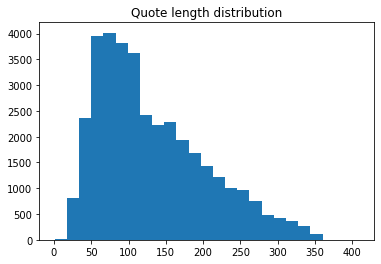

In [14]:
plt.title('Quote length distribution')
plt.hist(list(map(len, quotes)), bins=25);

### Creating a dictionary {symbol: id}:

In [15]:
tokens = list(set(''.join(quotes)))
token_to_id = {token: idx for idx, token in enumerate(tokens)}
num_tokens = len(tokens)

print(f"Number of unique tokens: {num_tokens}")

Number of unique tokens: 85


### Finding the appropriate batch size:

In [16]:
print(f"divisors of number of quotes ({quotes_n}) are {divisors(quotes_n)}")
batch_size = 214

divisors of number of quotes (36166) are [1, 2, 13, 26, 107, 169, 214, 338, 1391, 2782, 18083, 36166]


## Byte pair encoding (BPE) tokenization instead of characters using [youtokentome library](https://pypi.org/project/youtokentome/) :

In [17]:
num_tokens_bpe = 300
bpe_model_filename = "/tmp/quotes_bpe.yttm"
yttm.BPE.train(data=dataset_filename, vocab_size=num_tokens_bpe, model=bpe_model_filename)
tokenizer = yttm.BPE(bpe_model_filename)
quotes_bpe = tokenizer.encode(quotes, bos=True, eos=True)

___

## [Character GRU model](#scrollTo=2QZ4jvNtRoop&line=1&uniqifier=1):

In [18]:
EMB_SIZE = 128
HIDDEN_SIZE = 256
NUM_LAYERS = 3

char_gru_model = RNN_model("GRU", num_tokens, emb_size=EMB_SIZE, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS)

### [Training](#scrollTo=0-aBS-yD5Crc&line=1&uniqifier=1):

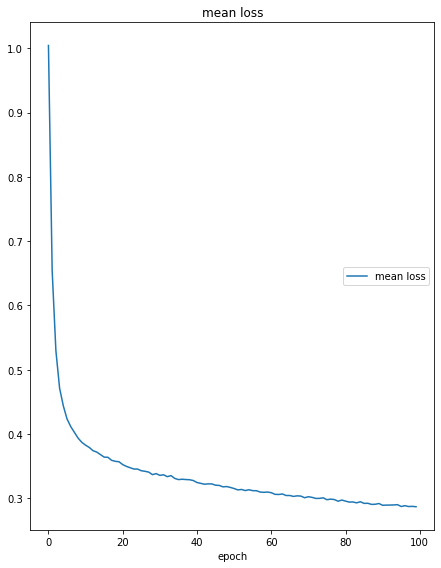

mean loss
	mean loss        	 (min:    0.287, max:    1.005, cur:    0.287)



In [19]:
# scheduler = lambda optim: \
#     torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5, factor=0.5, verbose=True)

scheduler = lambda optim: \
    torch.optim.lr_scheduler.StepLR(optim, step_size=10, gamma=0.95)

best_char_gru_loss, best_char_gru_model = train_eval_loop(model=char_gru_model,
                                                          dataset=quotes,
                                                          vocab=token_to_id,
                                                          lr=1e-3,
                                                          epoch_n=100,
                                                          batch_size=batch_size, 
                                                          early_stopping_patience=10,
                                                          l2_reg_alpha=0,
                                                          lr_scheduler_ctor=scheduler,
                                                          draw_loss=True)


### [Generating](#scrollTo=RN2bUYhoZJX2&line=1&uniqifier=1) new quotes by character GRU model:

In [20]:
for _ in range(10):
    print(generate_sample(best_char_gru_model, tokens, token_to_id, max_length=150, seed_phrase=' Neural networks', temperature=0.5, device='cpu'))

 Neural networks are about individuals. There is no such thing as a decent gift of being an individual to sound about what is concerned.              
 Neural networks are as great at the time they were able to defend themselves of themselves.                                                          
 Neural networks are the more our disposal that you can do and say.                                                                                   
 Neural networks will never be explained for your computer gardeners.                                                                                 
 Neural networks are always good at once, then what you can do in your life, and you are not something that you can get away from.                    
 Neural networks are as bad as they are as integrity as some level. They don't act out to be the shock.                                               
 Neural networks are not too late and I will not be affinitely ticket to the people I know.   

### Could save or load model: 

In [ ]:
# model_savepath = "/tmp/char_gru_model_" + best_char_gru_loss + ".pth"
# torch.save(best_char_gru_model.state_dict(), model_savepath)
# files.download(model_savepath)

# model_name = ""
# model_loadpath = f"/content/gdrive/My Drive/ML/models/{model_name}" 
# loaded_model = RNN_model("GRU", num_tokens, emb_size=EMB_SIZE, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS)
# loaded_model.load_state_dict(torch.load(model_loadpath))

___

## [BPE GRU model](#scrollTo=2QZ4jvNtRoop&line=1&uniqifier=1):

In [ ]:
EMB_SIZE = 128
HIDDEN_SIZE = 256
NUM_LAYERS = 3

bpe_gru_model = RNN_model("GRU", num_tokens_bpe, emb_size=EMB_SIZE, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS)

### [Training](#scrollTo=0-aBS-yD5Crc&line=1&uniqifier=1):

In [ ]:
# scheduler = lambda optim: \
#     torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5, factor=0.5, verbose=True)

scheduler = lambda optim: \
    torch.optim.lr_scheduler.StepLR(optim, step_size=5, gamma=0.95)

best_bpe_gru_loss, best_bpe_gru_model = train_eval_loop(model=bpe_gru_model,
                                                        dataset=quotes_bpe,
                                                        lr=1e-3,
                                                        epoch_n=150,
                                                        batch_size=batch_size, 
                                                        early_stopping_patience=10,
                                                        l2_reg_alpha=0,
                                                        lr_scheduler_ctor=scheduler,
                                                        draw_loss=True)


### [Generating](#scrollTo=AV8Bhw02i4sc&line=1&uniqifier=1) new quotes by BPE GRU model:

In [ ]:
for _ in range(10):
    print(generate_sample_bpe(best_bpe_gru_model, tokenizer, max_length=150, seed_phrase=' ', temperature=1.0, device='cpu'))